Датасет ежедневных изменений в цене акций:

In [ ]:
!wget https://raw.githubusercontent.com/phonetics-spbu/phonetics-spbu.github.io/main/public/courses/linear_models/files/FB_2.csv

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('FB_2.csv', header=0, parse_dates=[0])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-05-18,42.049999,45.000000,38.000000,38.230000,38.230000,573576400
1,2012-05-21,36.529999,36.660000,33.000000,34.029999,34.029999,168192700
2,2012-05-22,32.610001,33.590000,30.940001,31.000000,31.000000,101786600
3,2012-05-23,31.370001,32.500000,31.360001,32.000000,32.000000,73600000
4,2012-05-24,32.950001,33.209999,31.770000,33.029999,33.029999,50237200


Text(0, 0.5, 'Close')

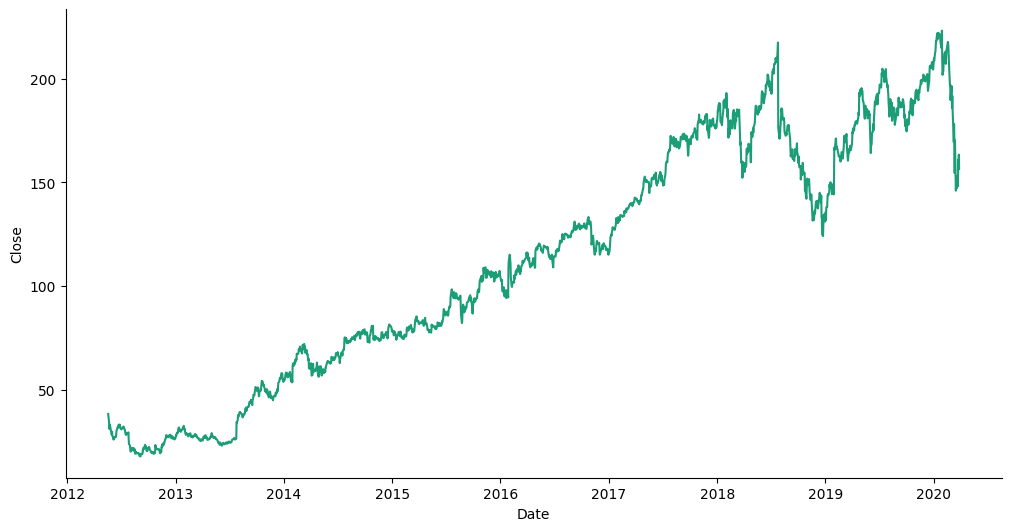

In [ ]:
# @title Date vs Close

from matplotlib import pyplot as plt
import seaborn as sns

def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Close']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
plt.ylabel('Close')

In [ ]:
close = df['Close']
dates = df['Date']
days = (dates - dates[0]) / np.timedelta64(1,'D')

Сгладим график методом скользящего среднего, M1=M2=M/2:

In [ ]:
M = 30
window = np.ones(M)
window /= sum(window)
smoothed = np.convolve(close, window, mode='valid')
smoothed_days = days[M//2: len(smoothed) + M//2]

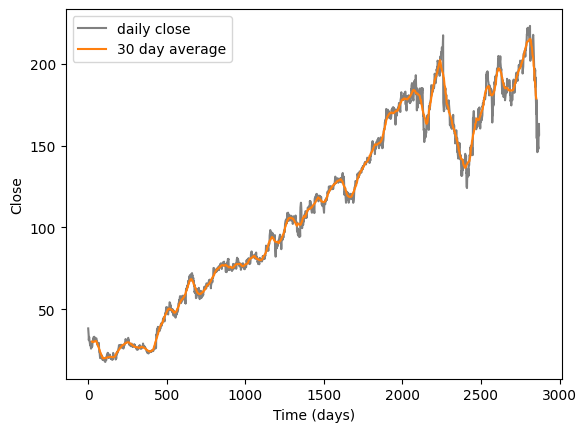

In [ ]:
plt.plot(days, close, color='gray', label='daily close')
plt.plot(smoothed_days, smoothed, color='C1', label='30 day average')

plt.xlabel('Time (days)')
plt.ylabel('Close')
plt.legend(loc='best')
plt.show()

Окно скользящего среднего похоже на прямоугольное, а значит, высокочастотные гармоники (соответствующие боковым лепесткам спектра окна) спадают медленно. Применим вместо прямоугольного фильтра гауссов, тем самым придавая кофэффициентам фильтра скользящего среднего разные веса.

In [ ]:
boxcar = np.ones(11)
boxcar /= sum(boxcar)

In [ ]:
import scipy

gaussian = scipy.signal.windows.gaussian(M=11, std=2)
gaussian /= sum(gaussian)

Text(0.5, 0, 'Index')

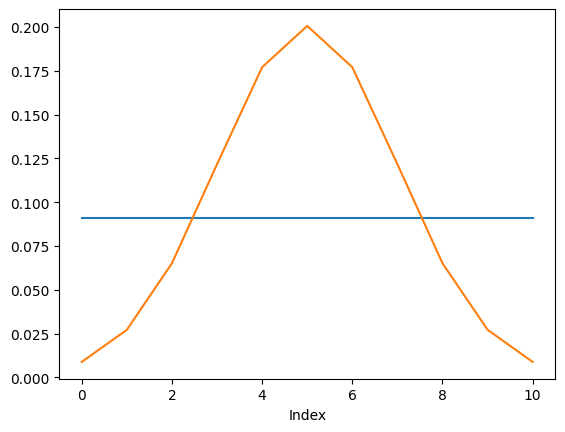

In [ ]:
plt.plot(boxcar, label='boxcar')
plt.plot(gaussian, label='Gaussian')
plt.xlabel('Index')

Свернем вектор входного сигнала с гауссовым окном

In [ ]:
window = scipy.signal.windows.gaussian(M=30, std=6)
window /= window.sum()
smoothed = np.convolve(close, window, mode='valid')

len(close), len(smoothed)

(1977, 1948)

Text(0, 0.5, 'Close')

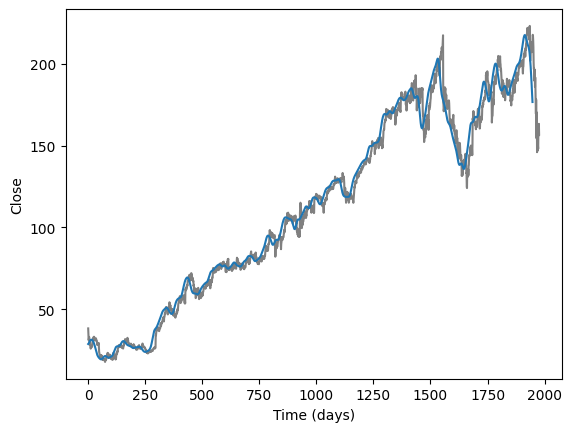

In [ ]:
plt.plot(close, color='gray')
plt.plot(smoothed)
plt.xlabel('Time (days)')
plt.ylabel('Close')


1977 30


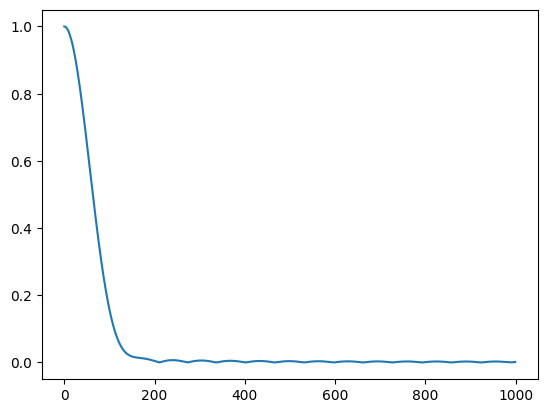

In [ ]:
N = len(close)
print(N, len(window))
padded = list(window)
padded.extend(np.zeros(N - len(window)))
fft_window = np.fft.fft(padded)
plt.plot(np.abs(fft_window[:1000]))

Второй способ: найдем ДПФ самого сигнала и вычислим свертку как ОДПФ произведений ДФП сигнала и окна (проверим теорему о свертке)

In [ ]:
fft_signal = np.fft.fft(close)
smoothed2 = np.fft.ifft(fft_signal * fft_window)
M = len(window)
smoothed2 = smoothed2[M-1:]

Text(0, 0.5, 'Close')

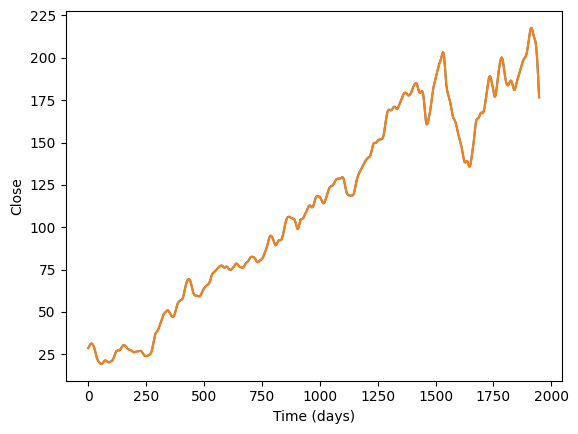

In [ ]:
plt.plot(smoothed)
plt.plot(smoothed2.real)
plt.xlabel('Time (days)')
plt.ylabel('Close')

Разница с прямым методом:

In [ ]:
diff = smoothed - smoothed2
np.max(np.abs(diff))

2.620352136458703e-13

Тоже самое можно сделать с помощью scipy:

In [ ]:
smoothed3 = scipy.signal.fftconvolve(close, window, mode='valid')

In [ ]:
diff = smoothed - smoothed3
np.max(np.abs(diff))

1.4210854715202004e-13

Своя функция для этого способа:

In [ ]:
def fft_convolve(signal, window):
    fft_signal = np.fft.fft(signal)
    fft_window = np.fft.fft(window)
    return np.fft.ifft(fft_signal * fft_window)

In [ ]:
smoothed4 = fft_convolve(close, padded)[M-1:]

In [ ]:
diff = smoothed - smoothed4
np.max(np.abs(diff))

2.620352136458703e-13